- Compare HSI emissions with Climate TRACE inventory and available literatural observation results

In [1]:
import os
from glob import glob
from itertools import chain
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import leafmap.foliumap as leafmap

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
# --- summary data ---
df_summary = pd.read_csv('../data/landfills_hyper_summary.csv', dtype={'metadata_report_year': str})
# units: t/h
# df_summary['emission'] = df_summary['emission']
# convert units from t/yr to t/h
df_summary['emissions_quantity'] /= (365*24)

# --- climate trace top 20 ---
df_climatetrace = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'metadata_report_year': str}, sheet_name='ClimateTrace_TOP20')
# convert units from t/yr to t/h
df_climatetrace['emissions_quantity'] /= (365*24)

# --- all HSI plume OBS ---
df_hyper_top20 = pd.read_excel('../data/landfills_hyper_obs.xlsx', sheet_name='ClimateTrace_TOP20')
# remove space at end
df_hyper_top20['name'] = df_hyper_top20['name'].str.strip()

# --- ground OBS data ---
df_obs = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'year': str}, sheet_name='OBS')
# units:t/h
df_obs['emission_obs'] = df_obs['emission(t/h)'] #/ 1e3 * 365 *24
df_obs['uncertainty_obs'] = df_obs['uncertainty(t/h)'] #/ 1e3 * 365 *24

# --- city emission ---
df_city = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'year': str}, sheet_name='Country_City')
# convert units from t/yr to t/h
df_city['ClimateTrace'] /= (365*24)
df_city['WasteMAP'] /= (365*24)


## Overview Folium Map

In [4]:
m = leafmap.Map()
m.add_basemap("Esri.WorldImagery")

# m.add_circle_markers_from_xy(geo_df_large, x="lon", y="lat", radius=5, color="none", fill_color='blue', fill_opacity=0.6, popup=['lon', 'lat', 'emissions_quantity', 'asset_name', 'iso3_country', 'start_time', 'end_time'])
m.add_circle_markers_from_xy(df_summary[['longitude', 'latitude', 'name']].dropna(), x="longitude", y="latitude", radius=5, color="none", fill_color='blue', fill_opacity=0.6,
                             popup=['longitude', 'latitude', 'name'],
                             max_width=500)

In [5]:
m.to_html('../figures/hyper.html')

## Merge HSI and Climate TRACE data

In [6]:
df_merge = df_summary.groupby(['country', 'name'], as_index=False)\
                     .agg({'emission':'mean', 'emission_uncertainty(%)': 'mean',
                           'emissions_quantity': 'mean',
                           'emissions_factor':'mean', 'capacity':'mean', 'activity':'mean', 'metadata_source': 'first', 'metadata_report_year': 'first',
                           })

# calculate uncertainty
df_merge['emission_uncertainty(t/h)'] = df_merge['emission']*df_merge['emission_uncertainty(%)']*1e-2

# only keep row which has climate trace data
df_merge_ct = df_merge.dropna(subset=['emissions_quantity'])

# rename column names
df_merge_ct = df_merge_ct[['country', 'name', 'emission', 'emissions_quantity', 'emission_uncertainty(t/h)', 'metadata_source', 'metadata_report_year']]\
      .rename(columns={'country': 'Country', 'name': 'Name', 'emission': 'HSI', 'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
                       'emissions_quantity': 'Climate TRACE', 'metadata_source': 'Report Source', 'metadata_report_year': 'Report Year'})
df_merge_ct['Report Year'] = df_merge_ct['Report Year'].str.rstrip('.0')

In [7]:
df_merge_ct

,Country,Name,HSI,Climate TRACE,HSI uncertainty (t h$^{-1}$),Report Source,Report Year
0,Argentina,González Catán,2.372215,2.177970,0.796463,Waste Atlas,2013
1,Argentina,Norte III,19.592599,3.256637,5.587416,Waste Atlas,2013
2,Argentina,Piedra Blanca,3.557083,1.701192,1.235710,METER/OSM,2022
3,Bangladesh,Aminbazar,3.775420,1.541889,1.844882,METER/OSM,2022
7,India,Bandhwari,2.364700,0.015812,0.770851,Global Plastic Watch,2021
8,India,Bhalswa,2.218554,1.377097,0.726758,Waste Atlas,2013
9,India,Deonar,2.025497,2.400635,0.647515,Waste Atlas,2013
10,India,Ghazipur,3.773879,1.956334,1.139325,Waste Atlas,2013
11,India,Hind,3.134605,0.349474,1.394884,Global Plastic Watch,2021
12,India,Kanjurmarg,9.453505,0.442059,2.402111,Global Plastic Watch,2021


In [8]:
# print latex table
print(df_merge_ct.rename(columns={'HSI': 'HSI (t h$^{-1}$)', 'Climate TRACE': 'Climate TRACE (t h$^{-1}$)'}).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llrrrll}
\toprule
Country & Name & HSI (t h$^{-1}$) & Climate TRACE (t h$^{-1}$) & HSI uncertainty (t h$^{-1}$) & Report Source & Report Year \\
\midrule
Argentina & González Catán &        2.4 &        2.2 &        0.8 & Waste Atlas & 2013 \\
Argentina & Norte III &       19.6 &        3.3 &        5.6 & Waste Atlas & 2013 \\
Argentina & Piedra Blanca &        3.6 &        1.7 &        1.2 & METER/OSM & 2022 \\
Bangladesh & Aminbazar &        3.8 &        1.5 &        1.8 & METER/OSM & 2022 \\
India & Bandhwari &        2.4 &        0.0 &        0.8 & Global Plastic Watch & 2021 \\
India & Bhalswa &        2.2 &        1.4 &        0.7 & Waste Atlas & 2013 \\
India & Deonar &        2.0 &        2.4 &        0.6 & Waste Atlas & 2013 \\
India & Ghazipur &        3.8 &        2.0 &        1.1 & Waste Atlas & 2013 \\
India & Hind &        3.1 &        0.3 &        1.4 & Global Plastic Watch & 2021 \\
India & Kanjurmarg &        9.5 &        0.4 &        2.4 & Global Plast

In [9]:
len(df_merge_ct)

26

In [10]:
# total emission t h-1
df_merge_ct['HSI'].sum()

122.652767840761

In [11]:
# uncertainty of total emission
np.sqrt(((df_merge_ct['HSI uncertainty (t h$^{-1}$)'])**2).sum())

9.212809646972186

In [12]:
# the total HSI emission is ??% higher than inventory
(df_merge_ct['HSI'].sum() - df_merge_ct['Climate TRACE'].sum())/df_merge_ct['Climate TRACE'].sum()

0.9606650759002865

## Fit HSI and Climate TRACE

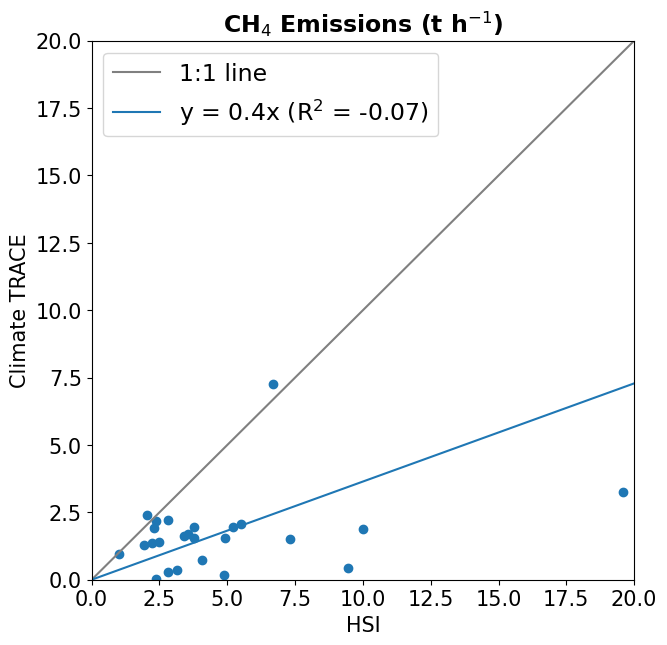

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))

x = df_merge_ct['HSI'].values
xerr = df_merge_ct['HSI uncertainty (t h$^{-1}$)']
y = df_merge_ct['Climate TRACE'].values

# Reshape the arrays to 2D
x_2d = x.reshape(-1, 1)
y_2d = y.reshape(-1, 1)

# Create and fit the linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(x_2d, y_2d)

# Get the slope of the linear regression line
slope = model.coef_[0][0]

# Calculate R-squared
r_squared = model.score(x_2d, y_2d)

plt.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='gray')
plt.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0')

ax.scatter(x, y)

ax.set_xlabel('HSI')
ax.set_ylabel('Climate TRACE')
ax.set_title('CH$_4$ Emissions (t h$^{-1}$)')

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

plt.legend()

# fig.savefig('../figures/hsi_climatetrace_fit.pdf')

## Matrix plot

In [14]:
def plot_stats(df):
    # https://stackoverflow.com/a/50690729/7347925
    def corrdot(*args, **kwargs):
        corr_r = args[0].corr(args[1], 'pearson')
        corr_text = f"{corr_r:2.2f}".replace("0.", ".")
        ax = plt.gca()
        ax.set_axis_off()
        marker_size = abs(corr_r) * 10000
        ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
                vmin=-1, vmax=1, transform=ax.transAxes)
        font_size = abs(corr_r) * 40 + 5
        ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                    ha='center', va='center', fontsize=font_size)

    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)

In [15]:
# plot_stats(df_merge[['emission', 'emissions_quantity', 'emissions_factor', 'capacity', 'activity']])

## City emission

In [16]:
def calc_city_emiss(row, df_merge):
    if pd.notna(row['landfills']):
        names = [name.lstrip() for name in row['landfills'].split(',')]
        df_city_subset = df_merge[df_merge['name'].isin(names)]
        emiss_mean = df_city_subset['emission'].sum().item()
        emiss_std = np.sqrt((df_city_subset['emission_uncertainty(t/h)']**2).sum()).item()
        return emiss_mean, emiss_std
    else:
        return np.nan, np.nan

In [17]:
df_city['HSI'], df_city['HSI uncertainty'] = zip(*df_city.apply(calc_city_emiss, args=(df_merge,), axis=1))

In [18]:
df_country = df_city.groupby(['country'], as_index=False)\
    .agg({'HSI': lambda x: x.sum(min_count=1), 
          'ClimateTrace': 'max',
          'WasteMAP': 'max',
        #   'HSI uncertainty': lambda x: np.sqrt(np.nansum(x**2)),
          'HSI uncertainty': lambda x: np.sqrt((x**2).sum(min_count=1)),
          })

In [19]:
# print latex table
df_city_subset = df_city[df_city['city']!='All'][['country', 'city', 'landfills', 'WasteMAP', 'HSI', 'HSI uncertainty']]\
      .rename(columns={'country': 'Country', 'city':'City', 'landfills': 'Landfills'})
df_city_subset['HSI/WasteMAP'] = np.round(df_city_subset['HSI']/df_city_subset['WasteMAP'], 1)

print(df_city_subset.rename(columns={'WasteMAP': 'WasteMAP (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'HSI uncertainty': 'HSI uncertainty (t h$^{-1}$)'})\
    .to_latex(index=False, float_format=lambda x: '%10.1f' % x)
    )

\begin{tabular}{lllrrrr}
\toprule
Country & City & Landfills & WasteMAP (t h$^{-1}$) & HSI (t h$^{-1}$) & HSI uncertainty (t h$^{-1}$) & HSI/WasteMAP \\
\midrule
Argentina & Buenos Aires & Norte III, González Catán &        3.8 &       22.0 &        5.6 &        5.8 \\
Mexico & Mexico City & Zumpango, Cuautitlán Izcalli, Chicoloapan de Juárez, Tecnosilicatos &       12.5 &       14.4 &        2.6 &        1.2 \\
Mexico & Monterrey & Simeprodeso &        0.3 &        5.5 &        2.0 &       16.3 \\
Brazil & São Paulo & São Paulo, Pedreira &        9.8 &       20.6 &        4.3 &        2.1 \\
Pakistan & Lahore & Lakhodair &        6.0 &        5.9 &        2.0 &        1.0 \\
Pakistan & Karachi & Jam Chakro &        5.3 &        5.2 &        1.8 &        1.0 \\
Saudi Arabia & Riyadh & Riyadh &       11.8 &       10.0 &        2.7 &        0.8 \\
Jordan & Amman & Ghabawi &        1.1 &        6.7 &        2.0 &        6.0 \\
Iran & Tehran & Tehran &        1.9 &        5.0 &        1.5 

In [20]:
# city emission > HSI or within 10%
df_city_subset['percent_diff'] = (df_city_subset['HSI']-df_city_subset['WasteMAP']) / df_city_subset['WasteMAP'] * 100
df_city_subset[(df_city_subset['percent_diff']<0) | (np.abs(df_city_subset['percent_diff'])<10)]

,Country,City,Landfills,WasteMAP,HSI,HSI uncertainty,HSI/WasteMAP,percent_diff
9,Pakistan,Lahore,Lakhodair,5.994749,5.876161,2.009615,1.0,-1.978201
10,Pakistan,Karachi,Jam Chakro,5.303539,5.200619,1.831998,1.0,-1.940591
13,Saudi Arabia,Riyadh,Riyadh,11.811644,10.016352,2.719873,0.8,-15.199342
20,Kuwait,Kuwait City,Seventh Ring Road,10.044406,7.305856,2.208587,0.7,-27.264429
29,Bangladesh,Dhaka,Aminbazar,3.892009,3.775420,1.844882,1.0,-2.995612
31,Yemen,Sanaa,Sanaa,1.589155,1.006493,0.403961,0.6,-36.664880


In [21]:
df_city_subset['HSI/WasteMAP'].mean()

5.459999999999999

In [22]:
df_city_subset.sort_values('HSI/WasteMAP')

,Country,City,Landfills,WasteMAP,HSI,HSI uncertainty,HSI/WasteMAP,percent_diff
31,Yemen,Sanaa,Sanaa,1.589155,1.006493,0.403961,0.6,-36.664880
20,Kuwait,Kuwait City,Seventh Ring Road,10.044406,7.305856,2.208587,0.7,-27.264429
13,Saudi Arabia,Riyadh,Riyadh,11.811644,10.016352,2.719873,0.8,-15.199342
9,Pakistan,Lahore,Lakhodair,5.994749,5.876161,2.009615,1.0,-1.978201
10,Pakistan,Karachi,Jam Chakro,5.303539,5.200619,1.831998,1.0,-1.940591
29,Bangladesh,Dhaka,Aminbazar,3.892009,3.775420,1.844882,1.0,-2.995612
4,Mexico,Mexico City,"Zumpango, Cuautitlán Izcalli, Chicoloapan de J...",12.502283,14.380346,2.550730,1.2,15.021759
7,Brazil,São Paulo,"São Paulo, Pedreira",9.826712,20.615297,4.274302,2.1,109.788339
18,Iran,Tehran,Tehran,1.911416,5.046604,1.500067,2.6,164.024432
27,Uzbekistan,Tashkent,Tashkent,0.935845,4.021951,1.432756,4.3,329.766929


In [23]:
df_country['HSI/ClimateTrace'] = df_country['HSI'] / df_country['ClimateTrace']
df_country['percent_diff'] = (df_country['HSI']-df_country['ClimateTrace']) / df_country['ClimateTrace'] * 100

In [24]:
# how much facility-level estimations lower than the country emissions
df_country[df_country['percent_diff']<0]['percent_diff'].mean()

-76.2586399293079

In [25]:
df_country.dropna(subset=['HSI', 'ClimateTrace']).sort_values('HSI/ClimateTrace')

,country,HSI,ClimateTrace,WasteMAP,HSI uncertainty,HSI/ClimateTrace,percent_diff
1,Bangladesh,3.775420,89.751431,24.543379,1.844882,0.042065,-95.793471
2,Brazil,20.615297,404.541209,247.716895,4.274302,0.050960,-94.904031
16,Yemen,1.006493,16.808562,11.301370,0.403961,0.059880,-94.012020
5,Iran,5.046604,71.072282,16.438356,1.500067,0.071007,-92.899336
10,Pakistan,11.076779,107.284831,55.251142,2.719332,0.103246,-89.675354
11,Saudi Arabia,10.016352,71.471716,59.474886,2.719873,0.140144,-85.985573
15,Uzbekistan,4.021951,15.569743,21.118721,1.432756,0.258318,-74.168159
12,Spain,4.932768,16.689826,56.621005,1.266388,0.295555,-70.444460
0,Argentina,21.964814,60.283345,24.429224,5.643897,0.364360,-63.564042
13,Tunisia,6.072865,6.142891,10.388128,2.255859,0.988600,-1.139955


In [26]:
print(df_country[['country', 'ClimateTrace', 'HSI', 'HSI uncertainty']].dropna(subset=['HSI', 'ClimateTrace'])\
      .rename(columns={'country': 'Country', 'ClimateTrace': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'HSI uncertainty': 'HSI uncertainty (t h$^{-1}$)'})\
        .to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{lrrr}
\toprule
Country & Climate TRACE (t h$^{-1}$) & HSI (t h$^{-1}$) & HSI uncertainty (t h$^{-1}$) \\
\midrule
Argentina &       60.3 &       22.0 &        5.6 \\
Bangladesh &       89.8 &        3.8 &        1.8 \\
Brazil &      404.5 &       20.6 &        4.3 \\
Iran &       71.1 &        5.0 &        1.5 \\
Jordan &        5.9 &        6.7 &        2.0 \\
Kuwait &        4.6 &        7.3 &        2.2 \\
Pakistan &      107.3 &       11.1 &        2.7 \\
Saudi Arabia &       71.5 &       10.0 &        2.7 \\
Spain &       16.7 &        4.9 &        1.3 \\
Tunisia &        6.1 &        6.1 &        2.3 \\
Uzbekistan &       15.6 &        4.0 &        1.4 \\
Yemen &       16.8 &        1.0 &        0.4 \\
\bottomrule
\end{tabular}



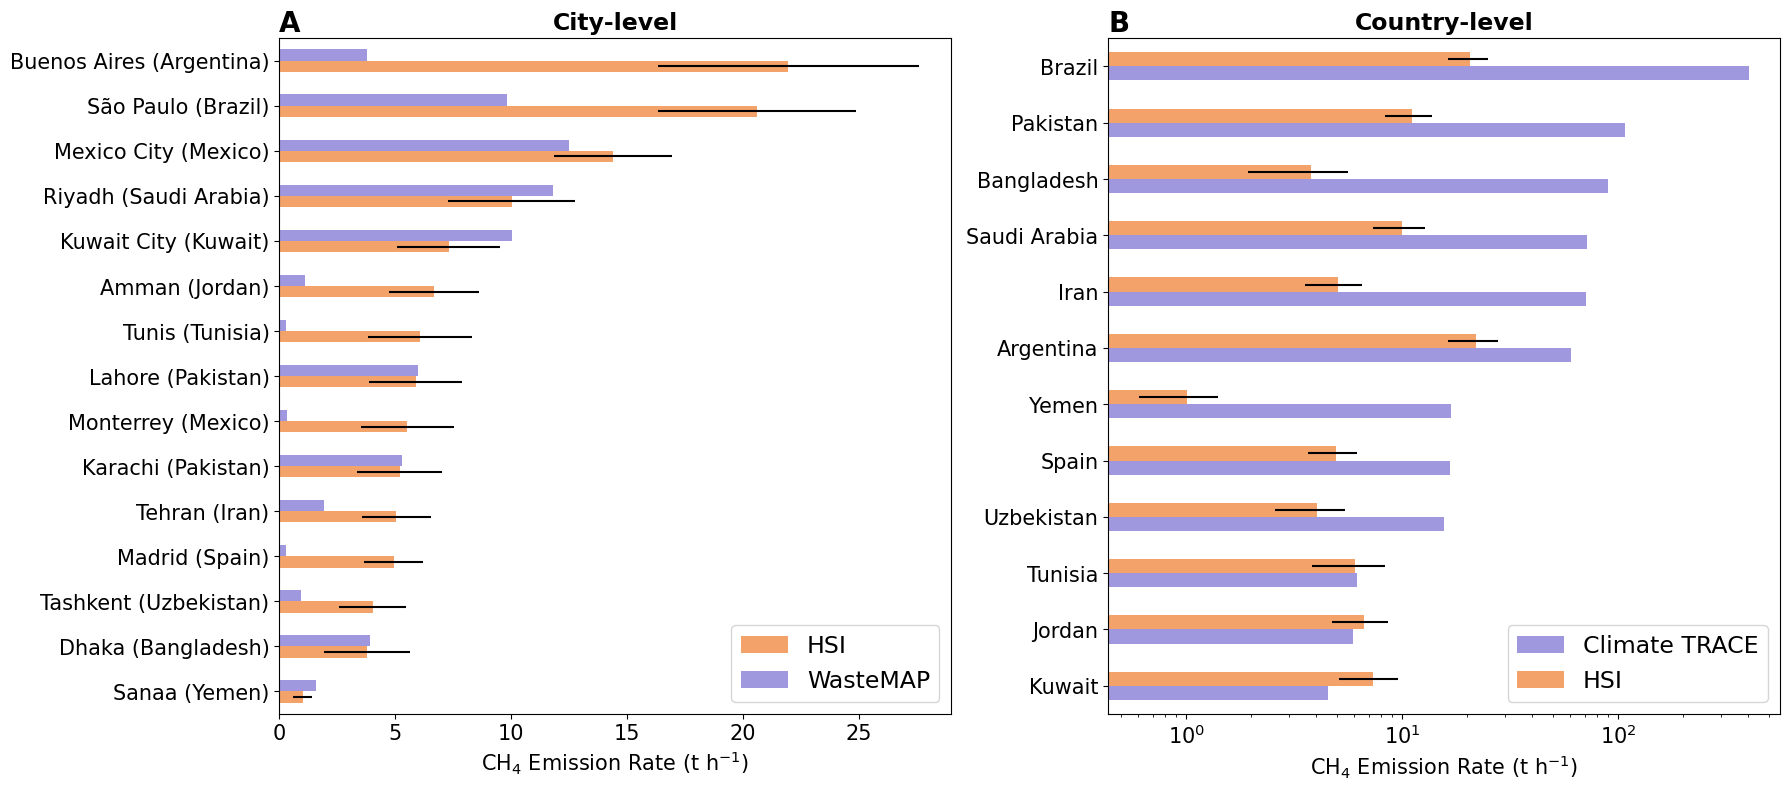

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 8))

axs = axs.flatten()

ax = axs[0]

# sort by HSI emission
df_city_subset_sort = df_city_subset.sort_values('HSI')
# set city name
df_city_subset_sort['City'] = df_city_subset_sort['City'] + ' (' + df_city_subset_sort['Country'] + ')'

df_city_subset_sort.plot(ax=ax,
                        x='City', y=['HSI', 'WasteMAP'],
                        xerr=[df_city_subset_sort['HSI uncertainty'],
                              [0]*len(df_city_subset),
                              ],
                        kind="barh",
                        color=['#f3a26a', '#9f98de']
                        )
ax.set_title('City-level')
ax.set_ylabel('')
ax.set_xlabel('CH$_4$ Emission Rate (t h$^{-1}$)')


ax = axs[1]

# sort by HSI emission
df_country_sort = df_country.dropna(subset=['HSI', 'ClimateTrace']).sort_values('ClimateTrace')\
                            .rename(columns={'ClimateTrace': 'Climate TRACE'})

df_country_sort.plot(ax=ax,
                        x='country', y=['Climate TRACE', 'HSI'],
                        xerr=[[0]*len(df_country_sort),
                              df_country_sort['HSI uncertainty'],
                              ],
                        kind="barh",
                        color=['#9f98de', '#f3a26a']
                        )

ax.set_xscale('log')
ax.set_title('Country-level')
ax.set_ylabel('')
ax.set_xlabel('CH$_4$ Emission Rate (t h$^{-1}$)')


for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.01, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_comp_city.pdf')

## OBS

In [28]:
df_merge_obs = df_obs.merge(df_merge[['name', 'emission', 'emission_uncertainty(%)', 'emission_uncertainty(t/h)']], on='name', how='left')

# keep landfills which have both HSI and OBS
df_merge_obs_nonan = df_merge_obs.dropna(subset=['emission_obs', 'emission']).reset_index(drop=True)

In [29]:
df_merge_obs_nonan

,country,name,latitude,longitude,emission(t/h),uncertainty(t/h),year,source,Reference,Unnamed: 9,emission_obs,uncertainty_obs,emission,emission_uncertainty(%),emission_uncertainty(t/h)
0,Argentina,Norte III,-34.529123,-58.622229,21.90,7.80,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,21.90,7.80,19.592599,28.517994,5.587416
1,Bangladesh,Aminbazar,23.798009,90.299357,2.17,NaN,2021,In-situ,https://doi.org/10.1016/j.cscee.2023.100302,NaN,2.17,NaN,3.775420,48.865621,1.844882
2,India,Ghazipur,28.623779,77.327769,1.60,1.10,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,1.60,1.10,3.773879,30.189748,1.139325
3,India,Kanjurmarg,19.123219,72.953469,6.40,4.00,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,6.40,4.00,9.453505,25.409740,2.402111
4,Iran,Tehran,35.458738,51.330033,5.00,1.00,2022,EMIT,https://doi.org/10.1126/sciadv.adh2391,NaN,5.00,1.00,5.046604,29.724282,1.500067
5,Pakistan,Lakhodair,31.625742,74.417881,7.10,3.10,2020,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,7.10,3.10,5.876161,34.199457,2.009615
6,Spain,Pinto,40.258962,-3.635696,6.57,0.93,2018,In-situ,https://doi.org/10.5194/acp-22-295-2022,NaN,6.57,0.93,4.932768,25.672967,1.266388
7,United States,Charlotte Motor Speedway,35.339296,-80.658488,0.88,0.30,2022,AVIRIS-NG,CarbonMapper,NaN,0.88,0.30,4.055145,29.594520,1.200101
8,United States,Seminole Road,33.662314,-84.257714,0.50,0.37,2022,ASU GAO,CarbonMapper,NaN,0.50,0.37,2.478385,27.529464,0.682286


In [30]:
# df_merge_obs_nonan['emission_uncertainty(t/h)'] = df_merge_obs_nonan['emission'] * df_merge_obs_nonan['emission_uncertainty(%)'] *1e-2

print(df_merge_obs_nonan.rename(columns={'country': 'Country', 'name': 'Name', 'latitude': 'Latitude', 'longitude': 'Longitude',
                                    'emission': 'HSI (t h$^{-1}$)', 'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
                                    'emission_obs': 'OBS (t h$^{-1}$)', 'uncertainty_obs': 'OBS uncertainty (t h$^{-1}$)',
                                    'year': 'OBS report year', 'source': 'OBS source'
                                    }
                                    )[['Country', 'Name', 'Latitude', 'Longitude', 'HSI (t h$^{-1}$)', 'OBS (t h$^{-1}$)',
                                       'HSI uncertainty (t h$^{-1}$)', 'OBS uncertainty (t h$^{-1}$)', 'OBS report year', 'OBS source',
                                    ]].fillna('-').to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llrrrrrlll}
\toprule
Country & Name & Latitude & Longitude & HSI (t h$^{-1}$) & OBS (t h$^{-1}$) & HSI uncertainty (t h$^{-1}$) & OBS uncertainty (t h$^{-1}$) & OBS report year & OBS source \\
\midrule
Argentina & Norte III &      -34.5 &      -58.6 &       19.6 &       21.9 &        5.6 &        7.8 & 2021 & GHGSat \\
Bangladesh & Aminbazar &       23.8 &       90.3 &        3.8 &        2.2 &        1.8 & - & 2021 & In-situ \\
India & Ghazipur &       28.6 &       77.3 &        3.8 &        1.6 &        1.1 &        1.1 & 2021 & GHGSat \\
India & Kanjurmarg &       19.1 &       73.0 &        9.5 &        6.4 &        2.4 &        4.0 & 2021 & GHGSat \\
Iran & Tehran &       35.5 &       51.3 &        5.0 &        5.0 &        1.5 &        1.0 & 2022 & EMIT \\
Pakistan & Lakhodair &       31.6 &       74.4 &        5.9 &        7.1 &        2.0 &        3.1 & 2020 & GHGSat \\
Spain & Pinto &       40.3 &       -3.6 &        4.9 &        6.6 &        1.3 &        0.9 & 

## Climate Trace top 20 landfills

### Validate csv and excel files

In [31]:
def validate_name(df_emiss, df):
    csv_name = df_emiss['name'].drop_duplicates()
    excel_name = df['name'].drop_duplicates()
    name_valid = csv_name.isin(excel_name)
    if all(name_valid):
        print('All csv landfill names are in the excel file')
    else:
        print(csv_name[~name_valid], 'is not in the excel file')

def append_excel_data(row, df):
    count = df[df['name']==row['name']][f"plume({row['platform'].lower()})"].item()
    overpass = df[df['name']==row['name']][f"overpass({row['platform'].lower()})"].item()

    return int(count), int(overpass)

In [32]:
top20_dir = '../data/Hyper_ClimateTrace20/'

filelist = list(chain(*[glob(os.path.join(top20_dir, '**', '*csv'), recursive=True)]))

df_top20 = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)

# add shape error
df_top20['emission_uncertainty'] = np.sqrt(df_top20['emission_uncertainty']**2+(df_top20['emission']*0.05)**2)
df_top20['emission_uncertainty(%)'] = df_top20['emission_uncertainty']/df_top20['emission']*100
# convert units from kg/h to t/h
df_top20['emission_uncertainty'] /= 1e3
df_top20['emission'] /= 1e3

df_top20_emiss = df_top20.groupby(['country', 'name', 'platform'], as_index=False)\
    .agg({'plume_longitude':'mean', 'plume_latitude':'mean', 'emission':'mean',
          'emission_uncertainty(%)': 'mean', 'plume_id': 'count'})\
    .rename(columns={'plume_id': 'plume_count', 'emission_uncertainty':'emission_uncertainty(t/h)'})

# remove space at end
df_top20_emiss['name'] = df_top20_emiss['name'].str.strip()

In [33]:
validate_name(df_top20_emiss, df_hyper_top20)

All csv landfill names are in the excel file


In [34]:
df_top20_emiss['count'], df_top20_emiss['overpass'] = zip(*df_top20_emiss.apply(append_excel_data, args=(df_hyper_top20,), axis=1))

# this should be empty
df_top20_emiss.query('plume_count != count')

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass


### Calculate mean emission and add Climate TRACE data

In [35]:
# assume 0 emission for no plume
df_top20_emiss['emission_mean'] = df_top20_emiss['emission']*df_top20_emiss['plume_count']/df_top20_emiss['overpass']
df_top20_emiss['emission_ratio'] = df_top20_emiss['emission_mean']/df_top20_emiss['emission']

In [36]:
df_top20_emiss

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass,emission_mean,emission_ratio
0,Chile,Loma Los Colorados,EMIT,-70.797246,-32.957113,8.572141,26.454609,2,2,2,8.572141,1.000000
1,China,West New Territories,EMIT,113.933249,22.418804,3.895579,21.316896,1,1,1,3.895579,1.000000
2,China,West New Territories,EnMAP,113.932410,22.419062,3.926833,30.998093,1,1,1,3.926833,1.000000
3,Greece,Fyli,EMIT,23.649628,38.075325,20.799086,28.331434,1,1,2,10.399543,0.500000
4,Iran,Tehran,EMIT,51.330033,35.458738,5.046604,29.780817,9,9,9,5.046604,1.000000
5,Jordan,Ghabawi,EMIT,36.187411,31.930061,6.675139,29.107908,14,14,14,6.675139,1.000000
6,Mexico,Los Laureles,PRISMA,-103.174977,20.545968,3.436654,17.468503,1,1,1,3.436654,1.000000
7,Mexico,Relleno Sanitario Portezuelos,EMIT,-116.744077,32.407891,6.858764,30.270881,4,4,4,6.858764,1.000000
8,Mexico,Relleno Sanitario Portezuelos,PRISMA,-116.747716,32.405726,9.947115,33.436879,1,1,1,9.947115,1.000000
9,Mexico,Relleno Sanitario Puebla,EMIT,-98.138243,18.982475,1.892880,45.318953,1,1,3,0.630960,0.333333


### Merge all data for TOP 20 landfills

In [37]:
df_merge_obs.columns

Index(['country', 'name', 'latitude', 'longitude', 'emission(t/h)',
       'uncertainty(t/h)', 'year', 'source', 'Reference', 'Unnamed: 9',
       'emission_obs', 'uncertainty_obs', 'emission',
       'emission_uncertainty(%)', 'emission_uncertainty(t/h)'],
      dtype='object')

In [38]:
# merge HSI and OBS
df_merge_all = df_top20_emiss[['country', 'name', 'platform', 'emission_mean', 'emission_uncertainty(%)']]\
    .merge(df_merge_obs[['country', 'name', 'emission_obs', 'uncertainty_obs', 'emission', 'emission_uncertainty(%)']],
                     on=['country', 'name'], how='left')

# add climate trace 20
df_merge_all = df_merge_all.merge(df_climatetrace[['name', 'emissions_quantity']], on='name', how='left')

# merge HSI emission
df_merge_all['HSI'] = df_merge_all[['emission_mean', 'emission']].bfill(axis=1).iloc[:, 0]
# df_merge_all['emission_uncertainty(t/h)'] = df_merge_all[['emission_uncertainty(t/h)_x', 'emission_uncertainty(t/h)_y']].bfill(axis=1).iloc[:, 0]
df_merge_all['emission_uncertainty(%)'] = df_merge_all[['emission_uncertainty(%)_x', 'emission_uncertainty(%)_y']].bfill(axis=1).iloc[:, 0]
df_merge_all['emission_uncertainty(t/h)'] = df_merge_all['HSI'] * df_merge_all['emission_uncertainty(%)'] * 1e-2

# rename columns for plot
df_merge_all.rename(columns={'emissions_quantity': 'Climate TRACE', 'emission_obs': 'OBS',
                             'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
                             'uncertainty_obs': 'OBS uncertainty',
                            },
                    inplace=True
                    )

# average HSI emissions of same landfill
df_merge_all = df_merge_all.groupby(['country', 'name'])[['Climate TRACE', 'HSI', 'HSI uncertainty (t h$^{-1}$)', 'OBS', 'OBS uncertainty']].mean().reset_index()

# sort by Climate TRACE emission data
df_merge_all = df_merge_all.sort_values('Climate TRACE', ascending=False).reset_index(drop=True)

# calculate and rename again for table
# df_merge_all['OBS uncertainty (%)'] = df_merge_all['OBS uncertainty']/df_merge_all['OBS']*100
df_merge_all.rename(columns={'country': 'Country', 'name': 'Name'}, inplace=True)

# modify name for xaxis
df_merge_all['xname'] = df_merge_all['Name'] + ' (' + df_merge_all['Country'] + ')'

In [39]:
df_merge_all

,Country,Name,Climate TRACE,HSI,HSI uncertainty (t h$^{-1}$),OBS,OBS uncertainty,xname
0,Iran,Tehran,20.455947,5.046604,1.502920,5.00,1.00,Tehran (Iran)
1,Mexico,Simeprodeso,17.866376,5.523757,2.016880,NaN,NaN,Simeprodeso (Mexico)
2,Chile,Loma Los Colorados,11.830760,8.572141,2.267726,0.91,0.23,Loma Los Colorados (Chile)
3,Mexico,Los Laureles,11.826663,3.436654,0.600332,NaN,NaN,Los Laureles (Mexico)
4,Greece,Fyli,10.184733,10.399543,2.946340,NaN,NaN,Fyli (Greece)
5,Mexico,Relleno Sanitario Portezuelos,9.266826,8.402940,2.701107,NaN,NaN,Relleno Sanitario Portezuelos (Mexico)
6,China,West New Territories,8.553950,3.911206,1.023830,NaN,NaN,West New Territories (China)
7,Mexico,Relleno Sanitario Puebla,7.794032,0.630960,0.285944,NaN,NaN,Relleno Sanitario Puebla (Mexico)
8,Jordan,Ghabawi,7.268989,6.675139,1.942993,NaN,NaN,Ghabawi (Jordan)


In [40]:
# print latex table
print(df_merge_all[['Country', 'Name', 'Climate TRACE',	'HSI', 'OBS', 'HSI uncertainty (t h$^{-1}$)', 'OBS uncertainty']].fillna('-')\
    .rename(columns={'Climate TRACE': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'OBS': 'OBS (t h$^{-1}$)', 'OBS uncertainty': 'OBS uncertainty (t h$^{-1}$)'})\
    .to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llrrlrl}
\toprule
Country & Name & Climate TRACE (t h$^{-1}$) & HSI (t h$^{-1}$) & OBS (t h$^{-1}$) & HSI uncertainty (t h$^{-1}$) & OBS uncertainty (t h$^{-1}$) \\
\midrule
Iran & Tehran &       20.5 &        5.0 &        5.0 &        1.5 &        1.0 \\
Mexico & Simeprodeso &       17.9 &        5.5 & - &        2.0 & - \\
Chile & Loma Los Colorados &       11.8 &        8.6 &        0.9 &        2.3 &        0.2 \\
Mexico & Los Laureles &       11.8 &        3.4 & - &        0.6 & - \\
Greece & Fyli &       10.2 &       10.4 & - &        2.9 & - \\
Mexico & Relleno Sanitario Portezuelos &        9.3 &        8.4 & - &        2.7 & - \\
China & West New Territories &        8.6 &        3.9 & - &        1.0 & - \\
Mexico & Relleno Sanitario Puebla &        7.8 &        0.6 & - &        0.3 & - \\
Jordan & Ghabawi &        7.3 &        6.7 & - &        1.9 & - \\
\bottomrule
\end{tabular}



## Combination into one plot

In [41]:
def fit_line(x, y):
    # Reshape the arrays to 2D
    x_2d = x.reshape(-1, 1)
    y_2d = y.reshape(-1, 1)

    # Create and fit the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(x_2d, y_2d)

    # Get the slope of the linear regression line
    slope = model.coef_[0][0]
    print(model.intercept_)

    # Calculate R-squared
    r_squared = model.score(x_2d, y_2d)

    return slope, r_squared

In [42]:
df_merge_obs_nonan

,country,name,latitude,longitude,emission(t/h),uncertainty(t/h),year,source,Reference,Unnamed: 9,emission_obs,uncertainty_obs,emission,emission_uncertainty(%),emission_uncertainty(t/h)
0,Argentina,Norte III,-34.529123,-58.622229,21.90,7.80,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,21.90,7.80,19.592599,28.517994,5.587416
1,Bangladesh,Aminbazar,23.798009,90.299357,2.17,NaN,2021,In-situ,https://doi.org/10.1016/j.cscee.2023.100302,NaN,2.17,NaN,3.775420,48.865621,1.844882
2,India,Ghazipur,28.623779,77.327769,1.60,1.10,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,1.60,1.10,3.773879,30.189748,1.139325
3,India,Kanjurmarg,19.123219,72.953469,6.40,4.00,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,6.40,4.00,9.453505,25.409740,2.402111
4,Iran,Tehran,35.458738,51.330033,5.00,1.00,2022,EMIT,https://doi.org/10.1126/sciadv.adh2391,NaN,5.00,1.00,5.046604,29.724282,1.500067
5,Pakistan,Lakhodair,31.625742,74.417881,7.10,3.10,2020,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,7.10,3.10,5.876161,34.199457,2.009615
6,Spain,Pinto,40.258962,-3.635696,6.57,0.93,2018,In-situ,https://doi.org/10.5194/acp-22-295-2022,NaN,6.57,0.93,4.932768,25.672967,1.266388
7,United States,Charlotte Motor Speedway,35.339296,-80.658488,0.88,0.30,2022,AVIRIS-NG,CarbonMapper,NaN,0.88,0.30,4.055145,29.594520,1.200101
8,United States,Seminole Road,33.662314,-84.257714,0.50,0.37,2022,ASU GAO,CarbonMapper,NaN,0.50,0.37,2.478385,27.529464,0.682286


In [43]:
df_merge_obs_nonan['type'] = 'Satellite'
df_merge_obs_nonan.loc[df_merge_obs_nonan.source.isin(['AVIRIS-NG', 'ASU GAO']), 'type'] = 'In-situ'
df_merge_obs_nonan.loc[df_merge_obs_nonan.source=='In-situ', 'type'] = 'Aircraft'

In [44]:
# # ------------ Gg yr-1 ------------
# fig, axs = plt.subplots(figsize=(8, 17), nrows=2)

# axs = axs.flatten()

# ax = axs[0]
# l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='k')

# # ---- HSI v.s. Climate TRACE ---
# x = df_merge_ct['HSI'].values
# xerr = x * df_merge_ct['HSI uncertainty (%)'] *1e-2
# y = df_merge_ct['Climate TRACE'].values

# slope, r_squared = fit_line(x, y)

# # l2 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0', linestyle='--')
# # l2 = ax.axline(xy1=(0, 0), slope=slope, label='Climate TRACE', c='C0', linestyle='--')
# ax.plot(range(300), slope*range(300), label='Climate TRACE', c='darkgray', linestyle='--', dashes=(3, 3), linewidth=3)

# # ax.scatter(x, y)
# ax.errorbar(x, y, xerr=xerr, c='darkgray', fmt='o', capsize=3, markersize=4, elinewidth=0.6)

# # ---- HSI v.s. OBS ---
# x = df_merge_obs_nonan['emission'].values
# xerr = x * df_merge_obs_nonan['emission_uncertainty(%)'] *1e-2
# y = df_merge_obs_nonan['emission_obs'].values
# yerr = df_merge_obs_nonan['uncertainty_obs'].values

# # import statsmodels.formula.api as smf
# # model = smf.ols('y~ x - 1', data={'x': x, 'y': y}).fit()
# # slope = model.params['x']
# # rsquared = model.rsquared

# slope, r_squared = fit_line(x, y)
# print('HSI v.s. OBS, slope: ', slope, 'R2: ', r_squared)
# # l3 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='darkorange', linestyle='--')
# # l3 = ax.axline(xy1=(0, 0), slope=slope, label='OBS', c='darkorange', linestyle='--')
# ax.plot(range(300), slope*range(300), label='OBS', c='#f3a26a', linestyle='--', dashes=(3, 3), linewidth=3)
# ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6, c='#f3a26a')

# # plot scatter
# # def dfScatter(df, ax, xcol='emission', ycol='emission_obs', catcol='type'):
# #     categories = np.unique(df[catcol])
# #     colors = np.linspace(0, 1, len(categories))
# #     colordict = dict(zip(categories, colors))  

# #     df["Color"] = df[catcol].apply(lambda x: colordict[x])
# #     ax.scatter(df[xcol], df[ycol], c=df.Color, cmap='viridis', s=4, zorder=10)

# # dfScatter(df_merge_obs_nonan, ax)

# ax.set_xlabel('HSI Estimation (Gg yr$^{-1}$)')
# ax.set_ylabel('CH$_4$ Emission Rate (Gg yr$^{-1}$)')

# ax.legend(loc='upper left')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1, 300)
# ax.set_ylim(1, 300)

# # ---- TOP 20 Climate Trace ----
# ax = axs[1]

# df_merge_all.plot(ax=ax,
#                 x='xname', y=['Climate TRACE', 'HSI', 'OBS'],
#                 yerr=[[0]*len(df_merge_all),
#                         df_merge_all['HSI']*df_merge_all['HSI uncertainty (%)']*1e-2,
#                         df_merge_all['OBS uncertainty'],
#                         ],
#                 kind="bar",
#                 # color=['darkgrey', 'C0', 'darkorange'],
#                 color=['darkgray', '#9f98de', '#f3a26a'],
#                 rot=90,
#                 )
# ax.set_xlabel('')
# ax.set_ylabel('CH$_4$ Emission Rate (Gg yr$^{-1}$)')
# ax.set_ylim(ymin=0)

# for n, ax in enumerate(axs):
#     # plot wind quivers
#     ax.text(0, 1.05, string.ascii_uppercase[n],
#             transform=ax.transAxes, 
#             size=20, weight='bold')

# fig.tight_layout()
# # fig.savefig('../figures/emission_comp.pdf')

0.0
0.0
HSI v.s. OBS, slope:  0.998899319528604 R2:  0.8838953280307361


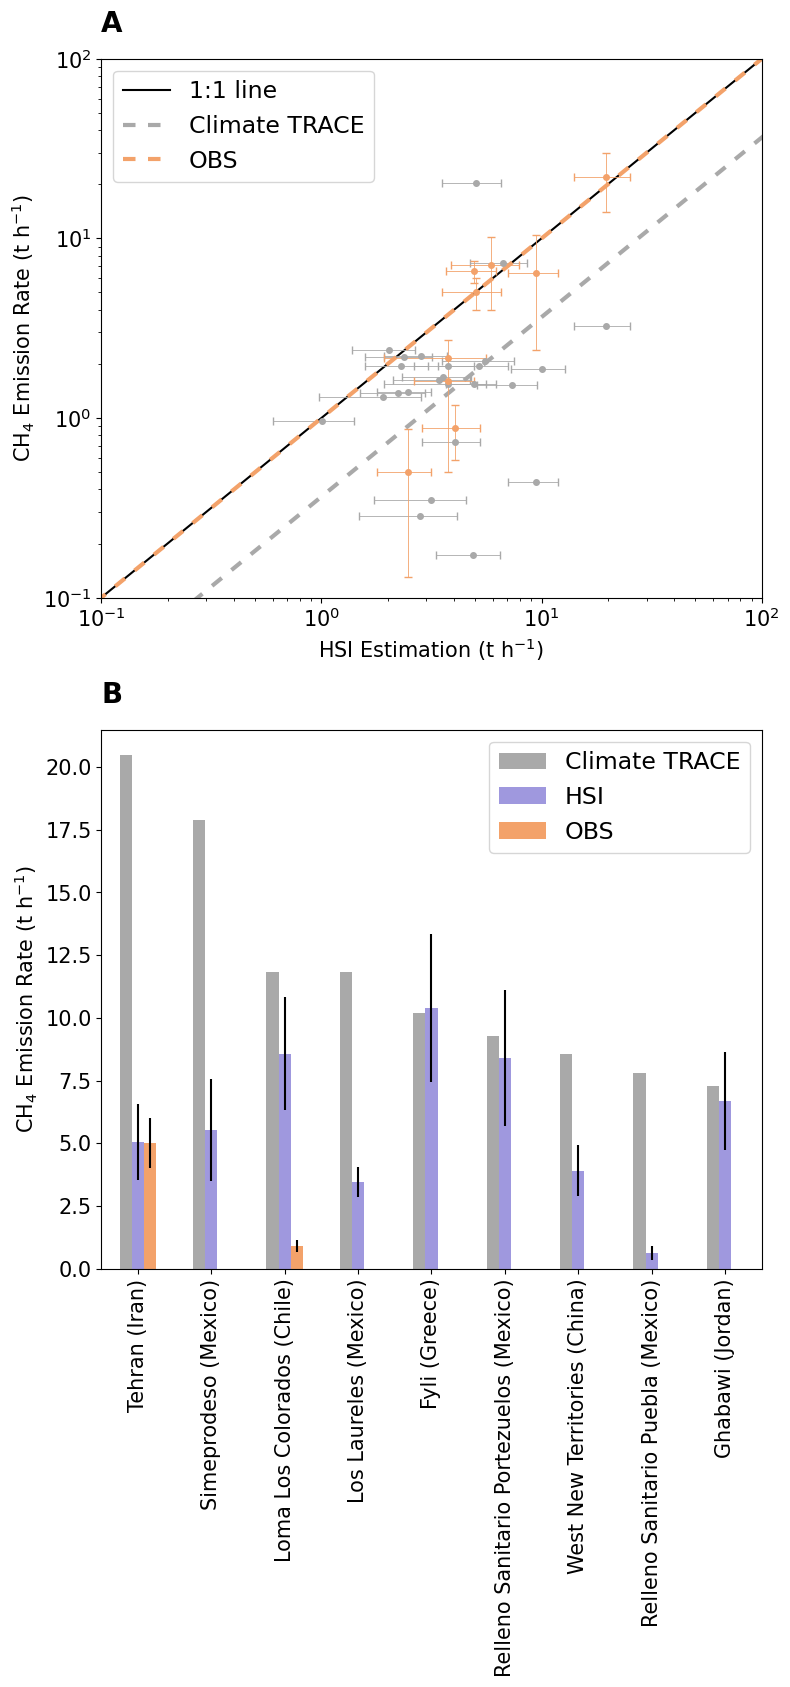

In [45]:
fig, axs = plt.subplots(figsize=(8, 17), nrows=2)

axs = axs.flatten()

ax = axs[0]
l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='k')

# ---- HSI v.s. Climate TRACE ---
x = df_merge_ct['HSI'].values # t/h
xerr = df_merge_ct['HSI uncertainty (t h$^{-1}$)']
y = df_merge_ct['Climate TRACE'].values  # t/h

slope, r_squared = fit_line(x, y)

# l2 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0', linestyle='--')
# l2 = ax.axline(xy1=(0, 0), slope=slope, label='Climate TRACE', c='C0', linestyle='--')
ax.plot(range(300), slope*range(300), label='Climate TRACE', c='darkgray', linestyle='--', dashes=(3, 3), linewidth=3)

# ax.scatter(x, y)
ax.errorbar(x, y, xerr=xerr, c='darkgray', fmt='o', capsize=3, markersize=4, elinewidth=0.6)

# ---- HSI v.s. OBS ---
x = df_merge_obs_nonan['emission'].values  # t/h
xerr = x * df_merge_obs_nonan['emission_uncertainty(%)'] * 1e-2
y = df_merge_obs_nonan['emission_obs'].values  # t/h
yerr = df_merge_obs_nonan['uncertainty_obs'].values  # t/h

# import statsmodels.formula.api as smf
# model = smf.ols('y~ x - 1', data={'x': x, 'y': y}).fit()
# slope = model.params['x']
# rsquared = model.rsquared

slope, r_squared = fit_line(x, y)
print('HSI v.s. OBS, slope: ', slope, 'R2: ', r_squared)
# l3 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='darkorange', linestyle='--')
# l3 = ax.axline(xy1=(0, 0), slope=slope, label='OBS', c='darkorange', linestyle='--')
ax.plot(range(300), slope*range(300), label='OBS', c='#f3a26a', linestyle='--', dashes=(3, 3), linewidth=3)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6, c='#f3a26a')

# plot scatter
# def dfScatter(df, ax, xcol='emission', ycol='emission_obs', catcol='type'):
#     categories = np.unique(df[catcol])
#     colors = np.linspace(0, 1, len(categories))
#     colordict = dict(zip(categories, colors))  

#     df["Color"] = df[catcol].apply(lambda x: colordict[x])
#     ax.scatter(df[xcol], df[ycol], c=df.Color, cmap='viridis', s=4, zorder=10)

# dfScatter(df_merge_obs_nonan, ax)

ax.set_xlabel('HSI Estimation (t h$^{-1}$)')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')

ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 100)
ax.set_ylim(0.1, 100)

# ---- TOP 20 Climate Trace ----
ax = axs[1]

df_merge_all.plot(ax=ax,
                x='xname', y=['Climate TRACE', 'HSI', 'OBS'],
                yerr=[[0]*len(df_merge_all),
                      df_merge_all['HSI uncertainty (t h$^{-1}$)'],
                        df_merge_all['OBS uncertainty'],
                        ],
                kind="bar",
                # color=['darkgrey', 'C0', 'darkorange'],
                color=['darkgray', '#9f98de', '#f3a26a'],
                rot=90,
                )
ax.set_xlabel('')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
ax.set_ylim(ymin=0)

for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.05, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_comp.pdf')

In [46]:
# Mean bias and RMSE for landfill hotspot comparison
bias = np.mean(df_merge_obs_nonan['emission'] - df_merge_obs_nonan['emission_obs'])
rmse = mean_squared_error(y_true=df_merge_obs_nonan['emission_obs'], y_pred=df_merge_obs_nonan['emission'], squared=False)
print('Mean bias: ', bias, 'RMSE: ', rmse)

Mean bias:  0.762718353432258 RMSE:  2.111533126460979


In [47]:
df_merge_all['hsi_ct_diff_percent'] = (df_merge_all['HSI'] - df_merge_all['Climate TRACE'])/df_merge_all['Climate TRACE']*1e2

In [48]:
df_merge_all

,Country,Name,Climate TRACE,HSI,HSI uncertainty (t h$^{-1}$),OBS,OBS uncertainty,xname,hsi_ct_diff_percent
0,Iran,Tehran,20.455947,5.046604,1.502920,5.00,1.00,Tehran (Iran),-75.329405
1,Mexico,Simeprodeso,17.866376,5.523757,2.016880,NaN,NaN,Simeprodeso (Mexico),-69.082943
2,Chile,Loma Los Colorados,11.830760,8.572141,2.267726,0.91,0.23,Loma Los Colorados (Chile),-27.543617
3,Mexico,Los Laureles,11.826663,3.436654,0.600332,NaN,NaN,Los Laureles (Mexico),-70.941475
4,Greece,Fyli,10.184733,10.399543,2.946340,NaN,NaN,Fyli (Greece),2.109139
5,Mexico,Relleno Sanitario Portezuelos,9.266826,8.402940,2.701107,NaN,NaN,Relleno Sanitario Portezuelos (Mexico),-9.322357
6,China,West New Territories,8.553950,3.911206,1.023830,NaN,NaN,West New Territories (China),-54.276020
7,Mexico,Relleno Sanitario Puebla,7.794032,0.630960,0.285944,NaN,NaN,Relleno Sanitario Puebla (Mexico),-91.904576
8,Jordan,Ghabawi,7.268989,6.675139,1.942993,NaN,NaN,Ghabawi (Jordan),-8.169626
